In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
import copy

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = (28, 28, 1)

In [3]:
def create_train_test_buckets(x_train, y_train, x_test, y_test):
    '''
    
    '''
    partitioned_train_arrays = {}
    numpy_partitioned_train_arrays = {}

    train_mix_fraction = 0.2
    test_mix_fraction = 0.2

    train_mix_length = int(len(x_train)*train_mix_fraction)
    test_mix_length = int(len(x_test)*test_mix_fraction)

    for item in zip(x_train,y_train):
        partitioned_train_arrays[item[1]]=([],[])

    for item in zip(x_train[:train_mix_length],y_train[:train_mix_length]):
        partitioned_train_arrays[item[1]][0].append(item[0])
        partitioned_train_arrays[item[1]][1].append(item[1])

    for item in zip(x_train[train_mix_length:],y_train[train_mix_length:]):
        random_bucket = int(np.random.randint(0,10,1))
        partitioned_train_arrays[random_bucket][0].append(item[0])
        partitioned_train_arrays[random_bucket][1].append(item[1])

    for item in partitioned_train_arrays:
        numpy_partitioned_train_arrays[item] = (np.array(partitioned_train_arrays[item][0]), np.array(partitioned_train_arrays[item][1]))

        
    partitioned_test_arrays = {}
    numpy_partitioned_test_arrays = {}


    for item in zip(x_test,y_test):
        partitioned_test_arrays[item[1]]=([],[])

    for item in zip(x_test[:test_mix_length],y_test[:test_mix_length]):
        partitioned_test_arrays[item[1]][0].append(item[0])
        partitioned_test_arrays[item[1]][1].append(item[1])

    for item in zip(x_test[test_mix_length:],y_test[test_mix_length:]):
        random_bucket = int(np.random.randint(0,10))
        partitioned_test_arrays[random_bucket][0].append(item[0])
        partitioned_test_arrays[random_bucket][1].append(item[1])


    for item in partitioned_test_arrays:
        partitioned_test_arrays[item] = (np.array(partitioned_test_arrays[item][0]), np.array(partitioned_test_arrays[item][1]))

    return(numpy_partitioned_train_arrays, partitioned_test_arrays)

In [4]:
partitioned_train_arrays, partitioned_test_arrays = create_train_test_buckets(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


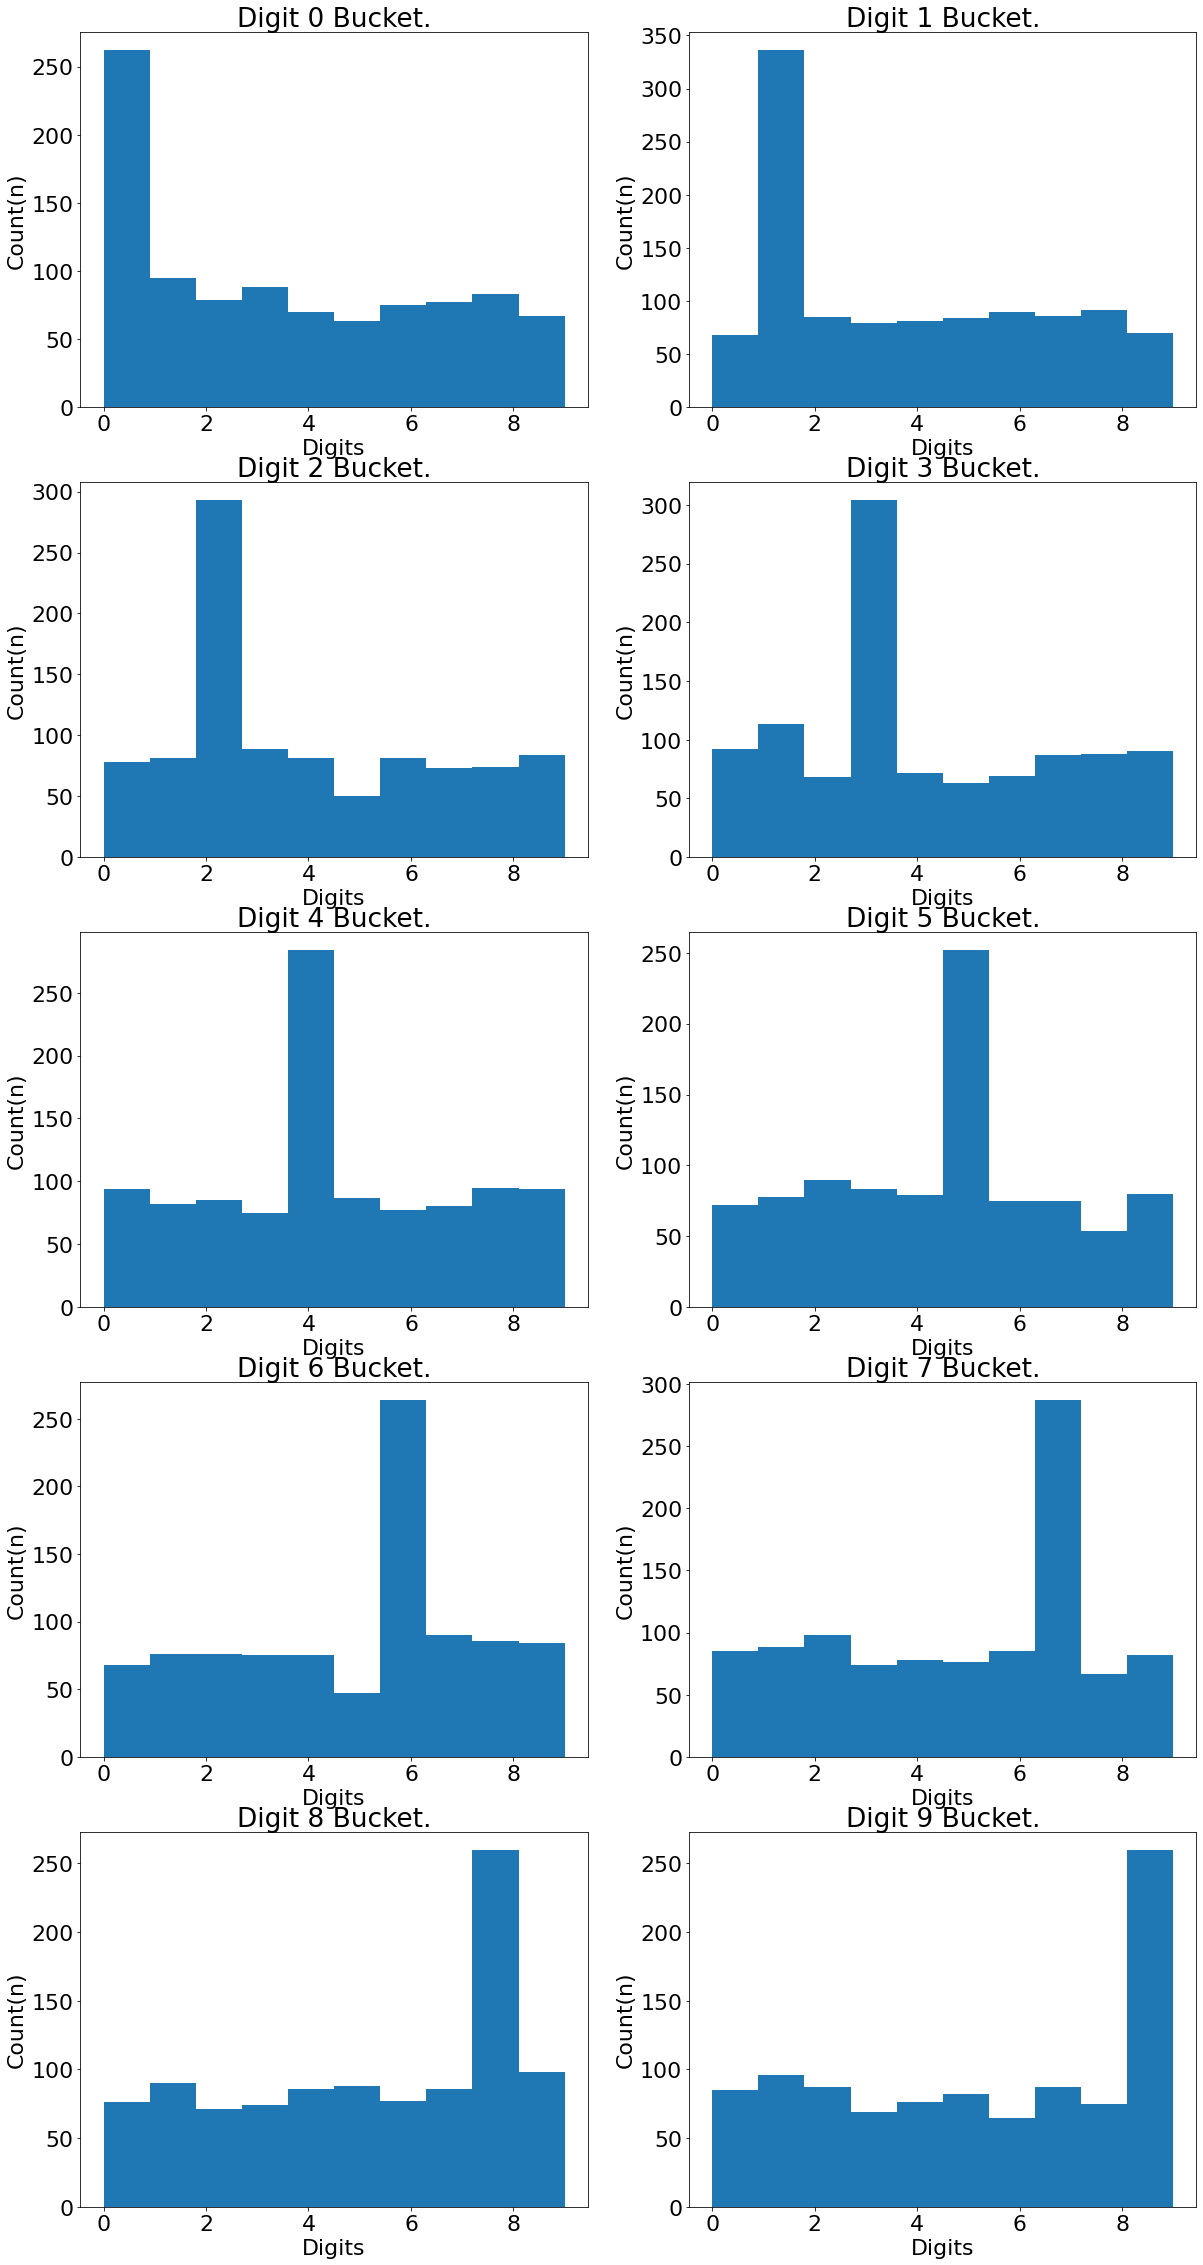

In [5]:
fig1, axs = plt.subplots(5,2, figsize=(20,40))
for row in range(5):
    for col in range(2):
        axs[row, col].hist(partitioned_test_arrays[row*2+col][1])
        axs[row, col].set_title('Digit {} Bucket.'.format(row*2+col))
        axs[row, col].set(xlabel='Digits', ylabel='Count(n)')

In [6]:
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(28, kernel_size=(5,5),input_shape=input_shape),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(14, kernel_size=(5,5)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(84,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

'numpy_partitioned_train_arrays' is dictionary with 10 keys corresponding to 0,1, ..., 9 digits.

In [7]:
def local_train(model, model_index, partitioned_train_arrays, partitioned_test_arrays, x_test, y_test, train_sample_count=100):
    x_train_reshaped = partitioned_train_arrays[model_index][0].reshape(-1,28,28,1)
    y_train_reshaped = partitioned_train_arrays[model_index][1]

    random_rows = np.random.choice(x_train_reshaped.shape[0], train_sample_count, replace=False)

    x_train_partitioned = x_train_reshaped[random_rows,:]
    y_train_partitioned = y_train_reshaped[random_rows]
    model.fit(x=x_train_partitioned, y=y_train_partitioned, epochs=1)
    
    x_test_partitioned = partitioned_test_arrays[model_index][0].reshape(-1,28,28,1)
    y_test_partitioned = partitioned_test_arrays[model_index][1]
    
    train_accuracy = model.evaluate(x_train_partitioned, y_train_partitioned)
    local_test_acciracy = model.evaluate(x_test_partitioned.reshape(-1,28,28,1), y_test_partitioned)
    global_test_accuracy = model.evaluate(x_test.reshape(-1,28,28,1), y_test)
    
    print('Accuracies: Training={}, Local Test={}, Global Test={}'.format(train_accuracy[1], local_test_acciracy[1], global_test_accuracy[1]))
    return(model, train_accuracy, local_test_acciracy, global_test_accuracy)
    

In [115]:
def average_models_weights(models_collection):
    '''
    '''
    
    weights = [models_collection[model].get_weights() for model in models_collection]

    new_weights = copy.copy(np.array(weights).mean(axis=0, out=None))

    new_model = create_keras_model()
#     new_model.compile(optimizer='adam',
#                       loss='sparse_categorical_crossentropy',
#                       metrics=['accuracy'])
    new_model.set_weights(new_weights)
    
    return(new_model)

## Regular Training (Non-Federated)

In [137]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
for item in range(2):
    models_collection['model_{}'.format(item)] = tf.keras.models.clone_model(model_global)
    
training_round = 25
training_round_accuracies_regular = []
train_sample_count=100
for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in models_collection:
        models_collection[model].compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        results = local_train(model=models_collection[model],
                        model_index=int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        #print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        #print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        models_collection[model] = tf.keras.models.clone_model(results[0])
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_regular.append(models_accuracies)

    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
Starting iteration: 0
313/313 [==============================] - 2s 8ms/step - loss: 20.0012 - accuracy: 0.1512
Accuracies: Training=0.3400000035762787, Local Test=0.2638164758682251, Global Test=0.15119999647140503
model_0 0.039593577
model_0 -0.065553874
313/313 [==============================] - 2s 8ms/step - loss: 11.5131 - accuracy: 0.2487
Accuracies: Training=0.5099999904632568, Local Test=0.3986928164958954, Global Test=0.24869999289512634
model_1 0.039593577
model_1 -0.06677454
Finieshed iteration: 0
Starting iteration: 1
313/313 [==============================] - 3s 9ms/step - loss: 10.9014 - accuracy: 0.3235
Accuracies: Training=0.5400000214576721, Local Test=0.4171011447906494, Global Test=0.32350000739097595
model_0 0.039324977
model_0 -0.06677454
142/313 [============>.................] - ETA: 1s - loss: 7.6517 - accuracy: 0.3187

KeyboardInterrupt: 

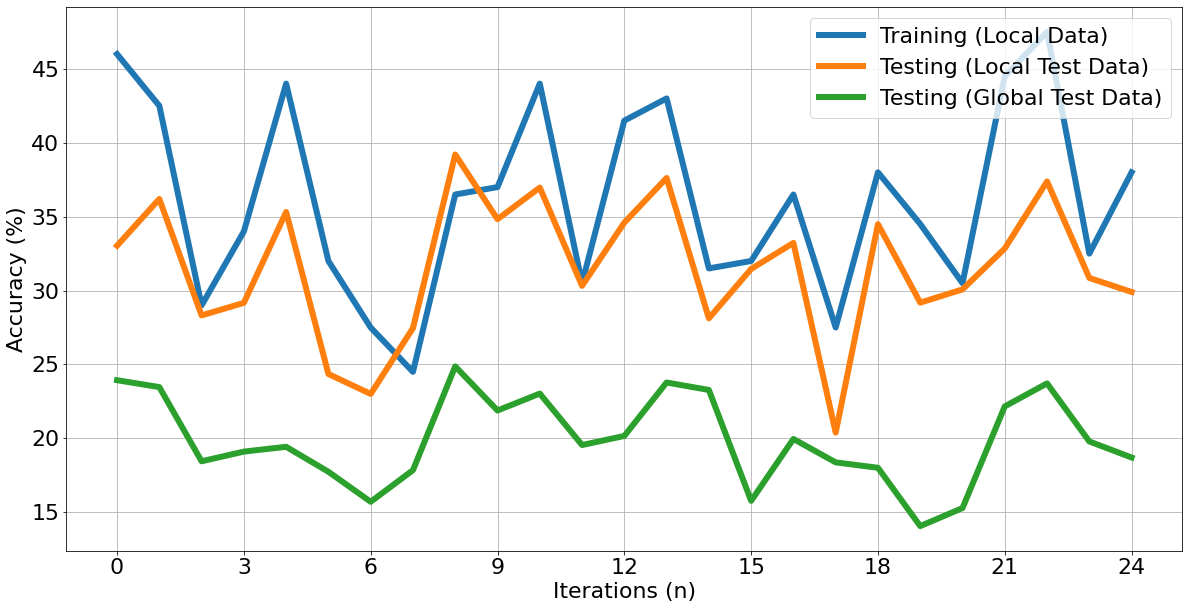

In [79]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_regular).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))



## Federated Learning

In [138]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
for item in range(2):
    models_collection['model_{}'.format(item)] = copy.copy(model_global)


training_round = 25
training_round_accuracies_federated_learning = []
train_sample_count=100
for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in models_collection:
        models_collection[model].compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        results = local_train(model=models_collection[model],
                        model_index=int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        
        '''
        Exteremely important to use "tf.keras.models.clone_model(results[0])" in the next
        line. Even copy.copy(results[0]) would produce a referenced model with the same weights/
        ''' 
        print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        models_collection[model] = tf.keras.models.clone_model(results[0])
        print('Model {} updated!'.format(model))
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_federated_learning.append(models_accuracies)
    print('Averaging Models')
    

    model_global = copy.copy(average_models_weights(models_collection))
    print('total model layers', np.shape(model_global.layers))

    models_collection = {}
    for item in range(2):
        models_collection['model_{}'.format(item)] = copy.copy(model_global)
    print('Model Memory IDs: {}, {}'.format(id(models_collection['model_0']),id(models_collection['model_1'])))
    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
Starting iteration: 0
313/313 [==============================] - 2s 8ms/step - loss: 12.9088 - accuracy: 0.2698
Accuracies: Training=0.4699999988079071, Local Test=0.41501563787460327, Global Test=0.26980000734329224
model_0 0.036093514
model_0 0.036093514
Model model_0 updated!
313/313 [==============================] - 2s 8ms/step - loss: 9.2677 - accuracy: 0.3240
Accuracies: Training=0.49000000953674316, Local Test=0.45471522212028503, Global Test=0.3240000009536743
model_1 -0.015302017
model_1 0.03299762
Model model_1 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 139981196154640, 139981932508552
Finieshed iteration: 0
Starting iteration: 1
313/313 [==============================] - 3s 8ms/step - loss: 3.7341 - accuracy: 0.1686
Accuracies: Training=0.30000001192092896, Local Test=0.22106361389160156, Global Test=0.16859999299049377
model_0 0.014124537
model_0 0.014124537
Model model_0 updated!
313/313 [==============================] -

313/313 [==============================] - 3s 8ms/step - loss: 3.9223 - accuracy: 0.2300
Accuracies: Training=0.2800000011920929, Local Test=0.3076120913028717, Global Test=0.23000000417232513
model_0 -0.042647306
model_0 -0.042647306
Model model_0 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.1340 - accuracy: 0.3250
Accuracies: Training=0.5199999809265137, Local Test=0.4761904776096344, Global Test=0.32499998807907104
model_1 -0.03288751
model_1 -0.045223232
Model model_1 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 139981620020224, 139981619688616
Finieshed iteration: 7
Starting iteration: 8
313/313 [==============================] - 2s 7ms/step - loss: 4.0513 - accuracy: 0.2022
Accuracies: Training=0.3400000035762787, Local Test=0.347236692905426, Global Test=0.2021999955177307
model_0 -0.005675154
model_0 -0.005675154
Model model_0 updated!
313/313 [==============================] - 3s 9ms/step - loss: 3.9507 - accuracy: 0.2588
Ac

313/313 [==============================] - 3s 9ms/step - loss: 3.0950 - accuracy: 0.2487
Accuracies: Training=0.3499999940395355, Local Test=0.376433789730072, Global Test=0.24869999289512634
model_0 -0.022973398
model_0 -0.022973398
Model model_0 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.1705 - accuracy: 0.3691
Accuracies: Training=0.5799999833106995, Local Test=0.48552754521369934, Global Test=0.36910000443458557
model_1 -0.0404592
model_1 -0.021262608
Model model_1 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 139981721411368, 139981718175816
Finieshed iteration: 14
Starting iteration: 15
313/313 [==============================] - 2s 7ms/step - loss: 3.5685 - accuracy: 0.2243
Accuracies: Training=0.4399999976158142, Local Test=0.2888425588607788, Global Test=0.22429999709129333
model_0 -0.021964053
model_0 -0.021964053
Model model_0 updated!
313/313 [==============================] - 2s 8ms/step - loss: 2.6634 - accuracy: 0.3524

313/313 [==============================] - 2s 8ms/step - loss: 4.1671 - accuracy: 0.2271
Accuracies: Training=0.46000000834465027, Local Test=0.3660062551498413, Global Test=0.22709999978542328
model_0 0.029079411
model_0 0.029079411
Model model_0 updated!
313/313 [==============================] - 3s 9ms/step - loss: 3.4445 - accuracy: 0.2034
Accuracies: Training=0.47999998927116394, Local Test=0.3837535083293915, Global Test=0.20340000092983246
model_1 0.0713352
model_1 0.029691353
Model model_1 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 139981647930312, 139981647932944
Finieshed iteration: 21
Starting iteration: 22
313/313 [==============================] - 2s 7ms/step - loss: 3.8594 - accuracy: 0.1849
Accuracies: Training=0.38999998569488525, Local Test=0.31699687242507935, Global Test=0.18490000069141388
model_0 0.07529422
model_0 0.07529422
Model model_0 updated!
313/313 [==============================] - 3s 10ms/step - loss: 3.0339 - accuracy: 0.2683
Ac

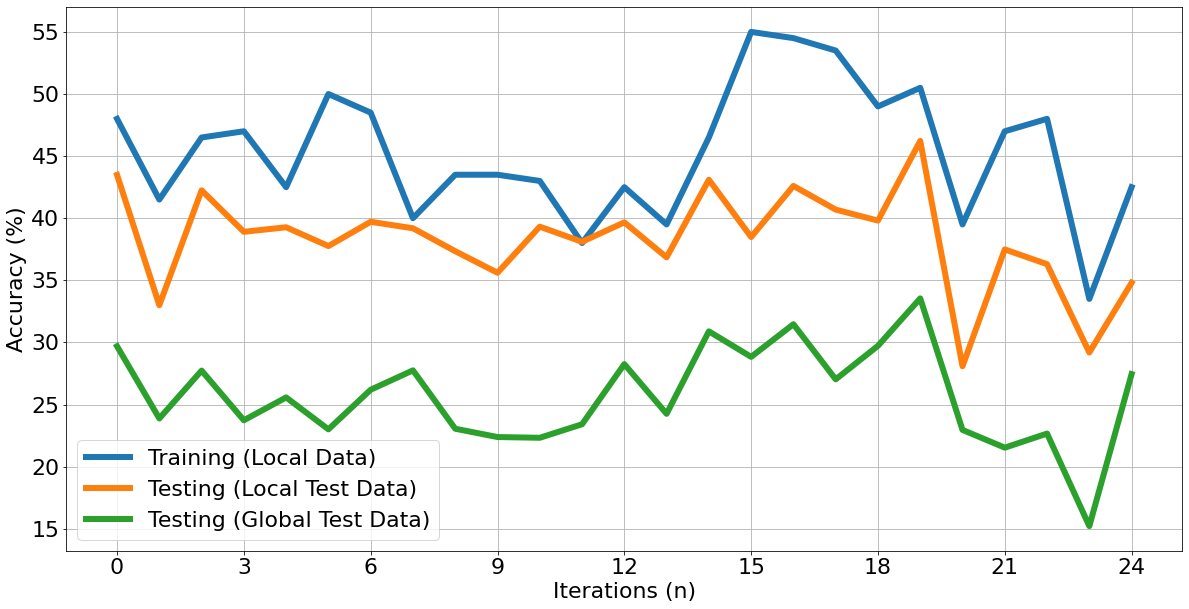

In [139]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_federated_learning).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))



In [30]:
len(training_round_accuracies_federated_learning)

50

## Federated Learning with Fine-Tuning

In [ ]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
for item in range(10):
    models_collection['model_{}'.format(item)] = tf.keras.models.clone_model(model_global)
    


training_round = 50
training_round_accuracies_finetuned = []
train_sample_count= 100
for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in models_collection:
        models_collection[model].compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        results = local_train(model=models_collection[model],
                        model_index=int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        '''
        Exteremely important to use "tf.keras.models.clone_model(results[0])" in the next
        line. Even copy.copy(results[0]) would produce a referenced model with the same weights/
        ''' 
        models_collection[model] = tf.keras.models.clone_model(results[0])
        
        print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_finetuned.append(models_accuracies)
    print('Averaging Models')
    
    if(iteration<10):
        model_global = average_models_weights(models_collection)
        print('total model layers', np.shape(model_global.layers))

        models_collection = {}
        for item in range(10):
            models_collection['model_{}'.format(item)] = model_global
    else:
        pass
    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
Starting iteration: 0
313/313 [==============================] - 2s 7ms/step - loss: 17.3093 - accuracy: 0.1697
Accuracies: Training=0.3400000035762787, Local Test=0.28050053119659424, Global Test=0.1696999967098236
model_0 -0.0062671825
model_0 0.07854977
313/313 [==============================] - 2s 7ms/step - loss: 26.4325 - accuracy: 0.1791
Accuracies: Training=0.4300000071525574, Local Test=0.2689075767993927, Global Test=0.17910000681877136
model_1 -0.0062671825
model_1 0.021796241
313/313 [==============================] - 3s 9ms/step - loss: 12.9859 - accuracy: 0.2467
Accuracies: Training=0.3700000047683716, Local Test=0.2835365831851959, Global Test=0.2467000037431717
model_2 -0.0062671825
model_2 0.021796241
313/313 [==============================] - 2s 7ms/step - loss: 19.5183 - accuracy: 0.1687
Accuracies: Training=0.3700000047683716, Local Test=0.25908222794532776, Global Test=0.16869999468326569
model_3 -0.0062671825
model_3 0.021796241
313/313 [=

313/313 [==============================] - 2s 7ms/step - loss: 0.8835 - accuracy: 0.7232
Accuracies: Training=0.7900000214576721, Local Test=0.7970244288444519, Global Test=0.7232000231742859
model_6 0.015116744
model_6 -0.054951143
313/313 [==============================] - 2s 7ms/step - loss: 0.6773 - accuracy: 0.7799
Accuracies: Training=0.8799999952316284, Local Test=0.813725471496582, Global Test=0.7799000144004822
model_7 0.015116744
model_7 -0.054951143
313/313 [==============================] - 2s 7ms/step - loss: 0.6457 - accuracy: 0.7912
Accuracies: Training=0.8500000238418579, Local Test=0.7713717818260193, Global Test=0.7911999821662903
model_8 0.015116744
model_8 -0.054951143
313/313 [==============================] - 2s 7ms/step - loss: 0.9652 - accuracy: 0.6492
Accuracies: Training=0.7900000214576721, Local Test=0.7057026624679565, Global Test=0.6492000222206116
model_9 0.015116744
model_9 -0.054951143
Averaging Models
total model layers (10,)
Finieshed iteration: 1
Star

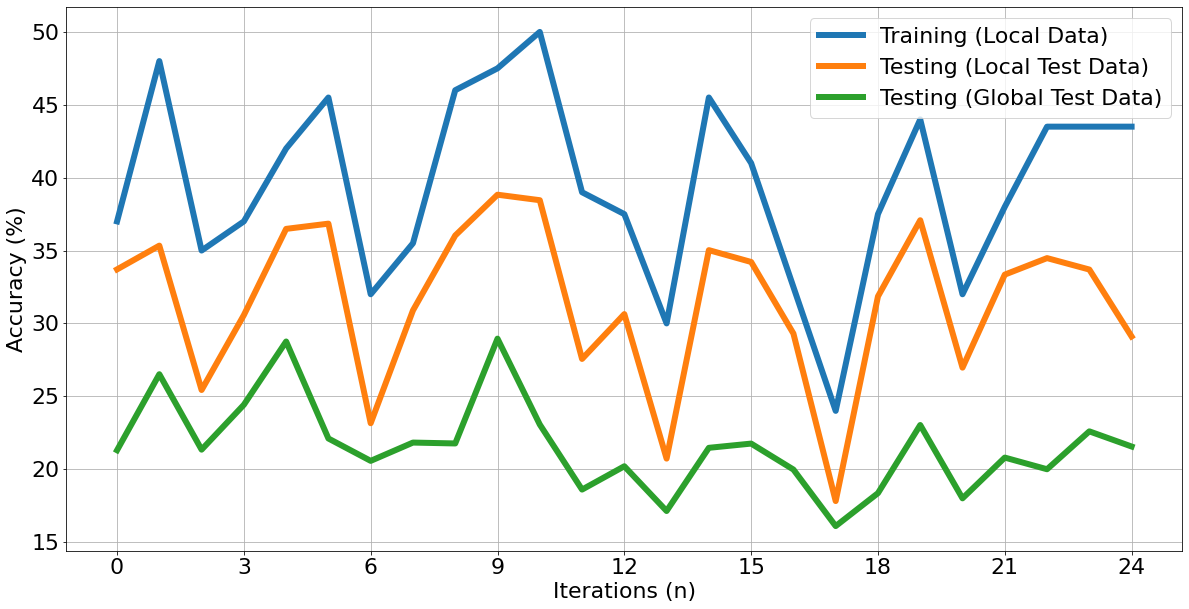

In [141]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_finetuned).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))

